### 前馈神经网络模型
两种方式，一种是循环预测，一种是直接出N年

其实还有第三种，每一年对应一个模型

循环预测：数据集被划分为6+5+5三段，前面的6为最开始的训练集X，中间的5为最开始的训练集Y，最后的5为测试集Y。训练时采取滑动窗口的模式，给定6个inputs，模型输出第7个的值。然后将窗口往前推。测试时不同的是，窗口往前推时，不填充真实值，而填充预测值

本文件基于时间划分测试集和训练集

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import *
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import EarlyStopping

random.seed(42)

读取数据

In [2]:
# (term_num, time_steps, feature_num)

gene_arr_path = r'../output/gene_editing/result.array'
transplant_arr_path = r'../output/transplant/old_school_decay.array'

gene_arr = pickle.load(open(gene_arr_path, mode='rb'))
transplant_arr = pickle.load(open(transplant_arr_path, mode='rb'))

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 17, 11)
Shape of the transplant array: (5141, 17, 11)


### 截断数据
因2019年两个数据集的EmergingScore大部分都为0，而2018年及之前的情况要好很多，故抛弃2019年数据

In [3]:
gene_arr = gene_arr[:, :-1, :]
transplant_arr = transplant_arr[:, :-1, :]

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 16, 11)
Shape of the transplant array: (5141, 16, 11)


### 规范数据并获取训练集和测试集
这里的训练集、测试集和序列模型的不同，是滑动窗口

因为不是序列模型，所以需要展平多变量序列，也可以使用多个神经网络对每一维进行处理

此外，因为是多变量序列，所以模型要预测所有的变量，不然没法循环输入

https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/

In [4]:
def to_supervised(data, n_inputs, n_outputs):
    X_train = list()
    X_test = list()
    y_train = list()
    y_test = list()
    
    for d in data:
        for i in range(n_outputs):
            X_train.append(d[i:i + n_inputs, :].flatten())
            y_train.append(d[i + n_inputs, :])
            X_test.append(d[-(n_inputs + n_outputs) + i:-n_outputs + i, :].flatten())
            y_test.append(d[-n_outputs + i, :])
            
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [5]:
scaler, data = scale_data(transplant_arr, 'standard')

# Direct
# X_train, X_test, y_train, y_test = split_data_by_time(data, 6, 5, False)

# Recursive
X_train, X_test, y_train, y_test = to_supervised(data, 6, 5)

In [6]:
X_test.shape

(25705, 66)

### 构建模型

In [7]:
def build_recursive_dnn_model():
    model = keras.models.Sequential()
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(11))
    model.compile(loss='mae', optimizer='adam')
    return model

def build_direct_dnn_model():
    model = keras.models.Sequential()
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(y_train.shape[1]))
    model.compile(loss='mae', optimizer='adam')
    return model

def build_parallel_dnn_model(n_inputs, n_vars):
    var = []
    denses = []
    
    for i in range(n_vars):
        v = Input(shape=(n_inputs))
        d = Dense(256, activation='relu')(v)
        var.append(v)
        denses.append(d)
    
    merge = concatenate(denses)
    d_2 = Dense(128)(merge)
    output = Dense(5)(d_2)
    
    model = Model(inputs=var, outputs=output)
    model.compile(loss='mae', optimizer='adam')
    
    return model

def build_parallel_X(data):
    Xs = []
    for i in range(data.shape[2]):
        Xs.append(data[:, :, i])
    return Xs

训练

In [21]:
model = build_direct_dnn_model()
history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_test, y_test), 
                   callbacks=[
                       
                   ])

Train on 5141 samples, validate on 5141 samples
Epoch 1/50
5141/5141 [==============================] - 2s 349us/sample - loss: 0.5117 - val_loss: 0.4940
Epoch 2/50
5141/5141 [==============================] - 1s 204us/sample - loss: 0.4862 - val_loss: 0.4946
Epoch 3/50
5141/5141 [==============================] - 1s 202us/sample - loss: 0.4794 - val_loss: 0.4906
Epoch 4/50
5141/5141 [==============================] - 1s 204us/sample - loss: 0.4764 - val_loss: 0.4925
Epoch 5/50
5141/5141 [==============================] - 1s 207us/sample - loss: 0.4728 - val_loss: 0.4937
Epoch 6/50
5141/5141 [==============================] - 1s 211us/sample - loss: 0.4690 - val_loss: 0.4901
Epoch 7/50
5141/5141 [==============================] - 1s 220us/sample - loss: 0.4627 - val_loss: 0.4946
Epoch 8/50
5141/5141 [==============================] - 1s 238us/sample - loss: 0.4577 - val_loss: 0.4987
Epoch 9/50
5141/5141 [==============================] - 1s 224us/sample - loss: 0.4552 - val_loss: 0.495

In [8]:
model = build_recursive_dnn_model()
history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_test, y_test), 
                   callbacks=[
                       
                   ])

Train on 25705 samples, validate on 25705 samples
Epoch 1/50
25705/25705 [==============================] - 6s 239us/sample - loss: 0.2612 - val_loss: 0.2492
Epoch 2/50
25705/25705 [==============================] - 5s 213us/sample - loss: 0.2438 - val_loss: 0.2388
Epoch 3/50
25705/25705 [==============================] - 6s 218us/sample - loss: 0.2406 - val_loss: 0.2402
Epoch 4/50
25705/25705 [==============================] - 6s 246us/sample - loss: 0.2388 - val_loss: 0.2371
Epoch 5/50
25705/25705 [==============================] - 7s 255us/sample - loss: 0.2374 - val_loss: 0.2437
Epoch 6/50
25705/25705 [==============================] - 7s 256us/sample - loss: 0.2364 - val_loss: 0.2311
Epoch 7/50
25705/25705 [==============================] - 7s 257us/sample - loss: 0.2352 - val_loss: 0.2407
Epoch 8/50
25705/25705 [==============================] - 7s 263us/sample - loss: 0.2346 - val_loss: 0.2424
Epoch 9/50
25705/25705 [==============================] - 7s 279us/sample - loss: 0.23

预测

In [9]:
def recursive_predict(model, X_test, n_inputs, n_outputs, n_features):
    # 只能用每个里面的第一部分，其他用预测来填充
    y_pred = []
    i = list(range(0, len(X_test), n_outputs))
    X = X_test[i]
    history = X.copy()
    
    for i in range(n_outputs):
        history = history[:, -n_features * n_inputs:]
        pred = model.predict(history)
        history = np.hstack([history, pred])
        y_pred.append(pred[:, -2].reshape(len(X), 1))
    return np.hstack(y_pred)

In [39]:
def recursive_predict(model, X_test, n_inputs, n_outputs, n_features):
    # 只能用每个里面的第一部分，其他用预测来填充
    # gap是用来跳过的
    y_pred = []
    i = 0
    while i < len(X_test):
        print(i)
        history = [num for num in X_test[i]]
        i += n_outputs
        inner_pred = []
        for j in range(n_outputs):
            X = np.array(history[-n_features * n_inputs:]).reshape(1, n_features * n_inputs)
            pred = list(model.predict(X)[0])
            inner_pred.append(pred[-2])
            history += pred
        y_pred.append(np.array(inner_pred))
    return np.array(y_pred)

In [10]:
# X_train, X_test, y_train, y_test = split_data_by_time(data, transplant_arr, 6, 5, False)
y_pred = recursive_predict(model, X_test, 6, 5, 11)
train_pred = recursive_predict(model, X_train, 6, 5, 11)

In [22]:
y_pred = model.predict(X_test)
train_pred = model.predict(X_train)

画图

In [12]:
# X_train, X_test, y_train, y_test, ids_train, ids_test = split_data_with_index(data, 11, 0.2)
X_train, X_test, y_train, y_test = split_data_by_time(data, 6, 5, False)

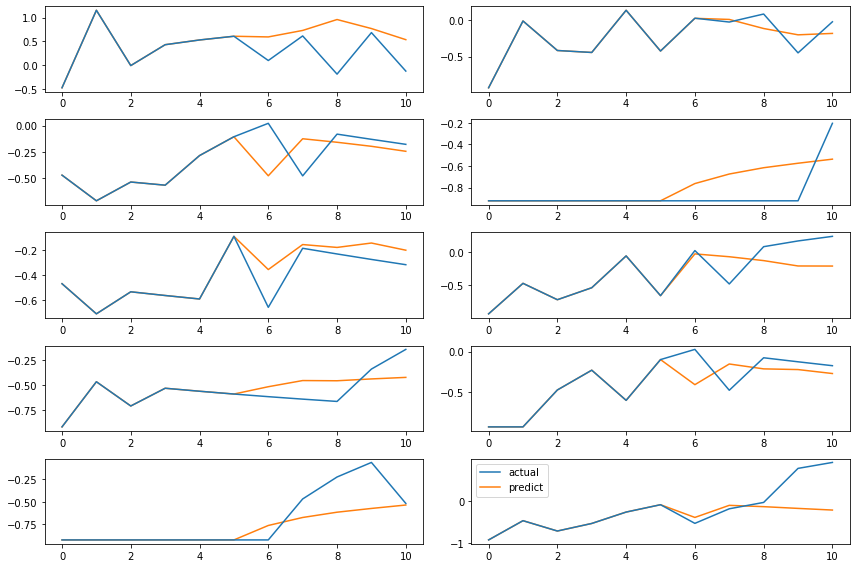

In [17]:
# 训练集
ids = random.sample(range(len(y_test)), 10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((X_train[ids[i], :, -2], y_train[ids[i]].reshape(-1)), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((X_train[ids[i], :, -2], train_pred[ids[i]].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

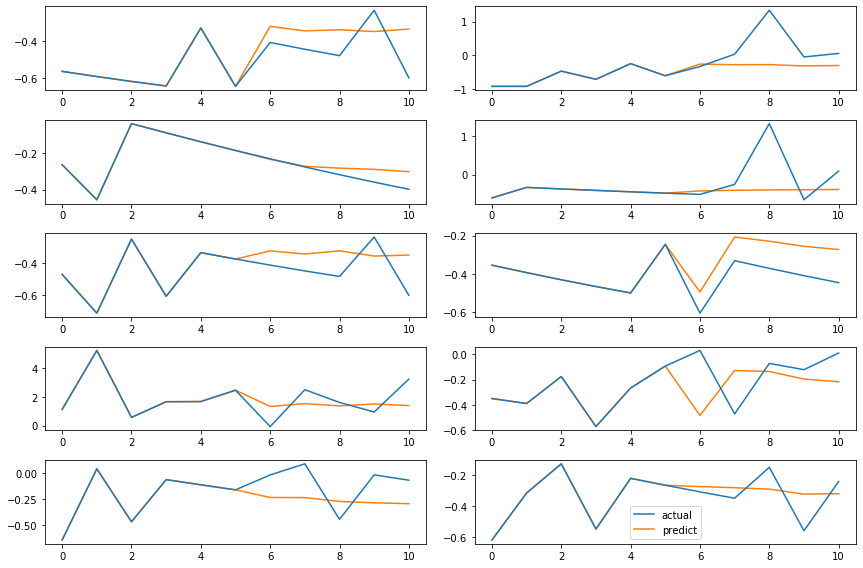

In [18]:
# 测试集
ids = random.sample(range(len(y_test)), 10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((X_test[ids[i], :, -2], y_test[ids[i]].reshape(-1)), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((X_test[ids[i], :, -2], y_pred[ids[i]].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

评估

MAE: 0.6826843243277599
MAEMAE: [0.64317159 0.66944923 0.66626721 0.69245338 0.74208021]


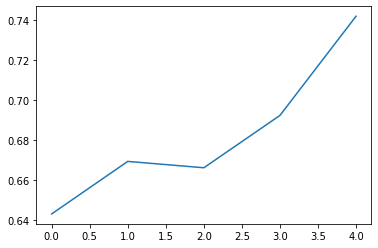

NDCG: 0.10270292855366342
NDCGMAE: [0.0012313803900734785, 0.001742732161426843, 0.0007734759371116358, 0.005521984122963604, 0.000825325151909279]


C:\Users\Tom Leung\OneDrive\文件\武汉大学\硕士投稿\主题热度预测\program\utils.py:36: RuntimeWarning: invalid value encountered in true_divide
  pred_score = np.sum((2 ** pred_array[:, 1] - 1) / np.log2(pred_array[:, 0] + 1))


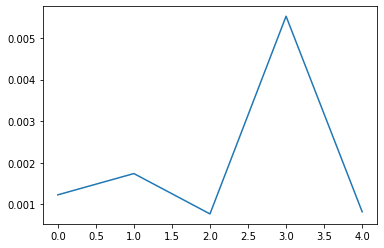

In [19]:
metrics = ['mae',  'ndcg']

for m in metrics:
    overall, annual = eval_model(m, y_test, y_pred, scaler)
    print('{}:'.format(m.upper()), overall)
    print('{}MAE:'.format(m.upper()),annual)
    plt.plot(annual)
    plt.show()

In [28]:
_y_true, _y_pred = eval_model('classification', y_test, y_pred, scaler)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(_y_true.reshape(-1), _y_pred.reshape(-1)))

              precision    recall  f1-score   support

         1.0       0.66      0.80      0.72     14768
         2.0       0.30      0.17      0.22      6860
         3.0       0.26      0.26      0.26      2600
         4.0       0.40      0.35      0.37      1477

    accuracy                           0.55     25705
   macro avg       0.41      0.39      0.39     25705
weighted avg       0.51      0.55      0.52     25705

